In [3]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.2 MB/s eta 0:00:00


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima

import itertools as it

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## load data

In [ ]:
files.upload()

In [6]:
df = pd.read_excel('emass.xlsx', parse_dates=['Date'])

## data understanding

In [7]:
df.shape, df.isna().sum()

((1258, 7),
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Adj       0
 Volume    0
 dtype: int64)

In [8]:
df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Adj     1258 non-null   float64       
 6   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.9+ KB


(None,
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj', 'Volume'], dtype='object'))

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2023-11-10,1959.6,1959.6,1932.6,1932.6,1932.6,10
1,2023-11-09,1951.7,1964.2,1945.3,1964.2,1964.2,10
2,2023-11-08,1967.8,1967.8,1947.7,1951.5,1951.5,43
3,2023-11-07,1966.5,1966.8,1960.7,1966.8,1966.8,20
4,2023-11-06,1981.6,1981.6,1977.4,1981.6,1981.6,130


In [10]:
df = df.sort_values('Date')

In [11]:
df['stationer'] = df['Close'].diff()
df.dropna(inplace=True)

## data preparation

In [12]:
datastationer, datatrend = df[['Date', 'stationer']].set_index('Date'), df[['Date', 'Close']].set_index('Date')

<Axes: xlabel='Date'>

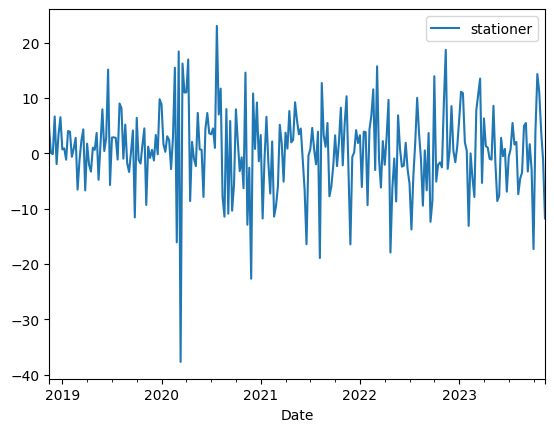

In [13]:
datastationer = datastationer.resample('W').mean()
datastationer.plot()

In [14]:
testadfuller = adfuller(datastationer)
print(f'p-value = {testadfuller[1]}')

p-value = 8.957733278071645e-17


In [15]:
datastationer.head(), datastationer.tail()

(            stationer
 Date                 
 2018-11-18      4.875
 2018-11-25      0.050
 2018-12-02     -0.160
 2018-12-09      6.650
 2018-12-16     -1.960,
             stationer
 Date                 
 2023-10-15     14.320
 2023-10-22     11.040
 2023-10-29      3.980
 2023-11-05     -1.175
 2023-11-12    -11.780)

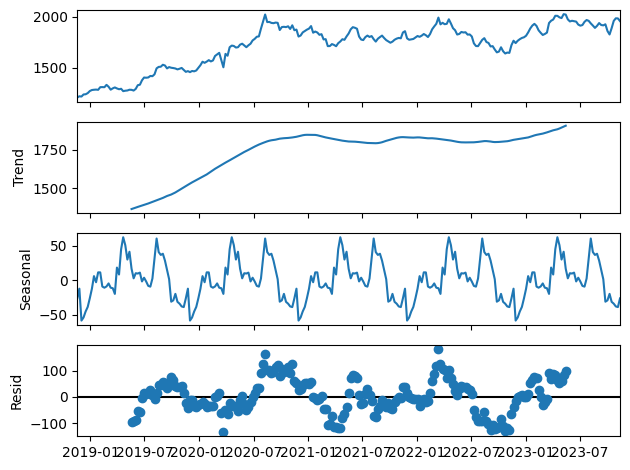

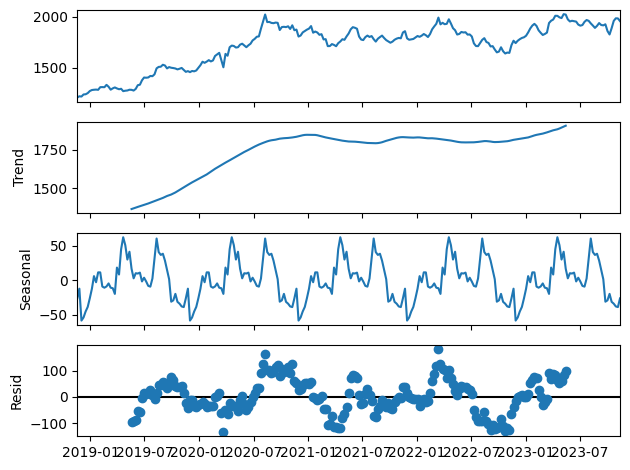

In [16]:
datatrend = datatrend.resample('W').mean()
decomposed = seasonal_decompose(datatrend, model='additive')
decomposed.plot()

In [17]:
datatrend.head(), datatrend.tail()

(               Close
 Date                
 2018-11-18  1210.175
 2018-11-25  1222.225
 2018-12-02  1219.420
 2018-12-09  1239.975
 2018-12-16  1241.940,
                Close
 Date                
 2023-10-15  1890.320
 2023-10-22  1961.040
 2023-10-29  1986.220
 2023-11-05  1985.275
 2023-11-12  1959.340)

## split train-test

In [18]:
datatrend.shape

(261, 1)

In [19]:
261*0.25

65.25

In [75]:
trainstationer = datastationer.iloc[:-52]
teststationer = datastationer.iloc[-52:]

traintrend = datatrend.iloc[:-52]
testtrend = datatrend.iloc[-52:]
traintrend.head(1), traintrend.tail(1)

(               Close
 Date                
 2018-11-18  1210.175,
              Close
 Date              
 2022-11-13  1723.0)

# Modelling

## menggunakan pmdarima

In [49]:
def fungsi_pmd(data, season, step):
  modelpmd = auto_arima(data,
                        seasonal=season,
                        n=step,
                        information_criterion='aicc',
                        suppress_warnings=True,
                        random_state=42)
  return modelpmd

In [51]:
fungsi_pmd(trainstationer, False, 12)

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [79]:
def fungsi_arima(train, test, param, station):
  modelarima = ARIMA(train,
                     order=param,
                     enforce_stationarity=station,
                     enforce_invertibility=station)
  arimafit = modelarima.fit()
  prediksiarima = arimafit.predict(start = '2018-11-18', end ='2023-11-12')
  plt.plot(test, label='test', color='b')
  plt.plot(prediksiarima, label='prediksi', color='r')
  plt.plot(train, label='train', color='g')
  plt.legend()
  return
  plt.show()

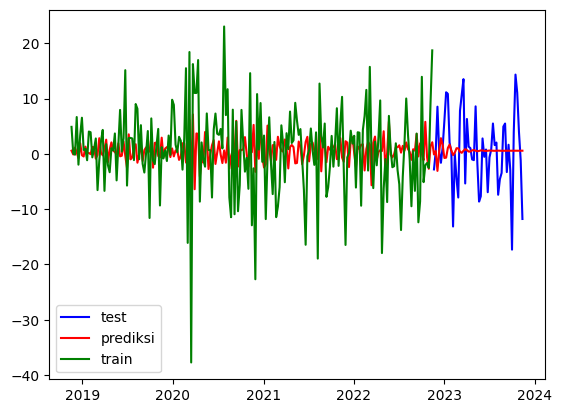

In [80]:
fungsi_arima(trainstationer, teststationer, (3, 0, 2), True)

In [49]:
fungsi_pmd(traintrend, True, 4)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

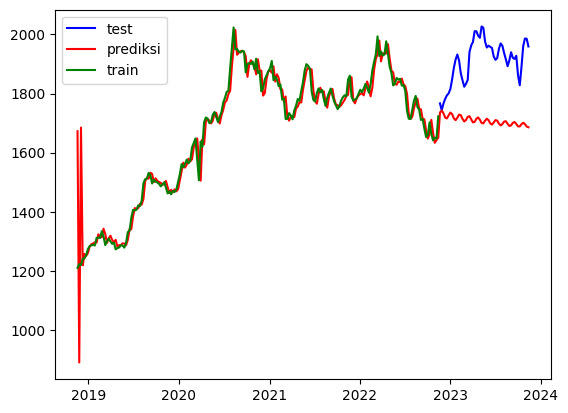

In [81]:
fungsi_arima(traintrend, testtrend, (3, 0, 2), False)

##dengan fungsi

In [21]:
p = d = q = range(0,3)
pdq = list(it.product(p,d,q))

In [83]:
def grid_Arima(data, param, station):
    hasil = []
    for x in param:
      try:
        mod = ARIMA(data,
                    order = x,
                    enforce_stationarity = station,
                    enforce_invertibility = station)
        output = mod.fit()
        hasil.append([x, output.aic])
      except:
        continue
    dfhasil = pd.DataFrame(hasil, columns=['parameter', 'aic'])
    dfhasil = dfhasil.sort_values(by = ['aic'],ascending=True)[0:1]
    return dfhasil

In [84]:
grid_Arima(traintrend, pdq, False)

,parameter,aic
8,"(0, 2, 2)",1974.27101


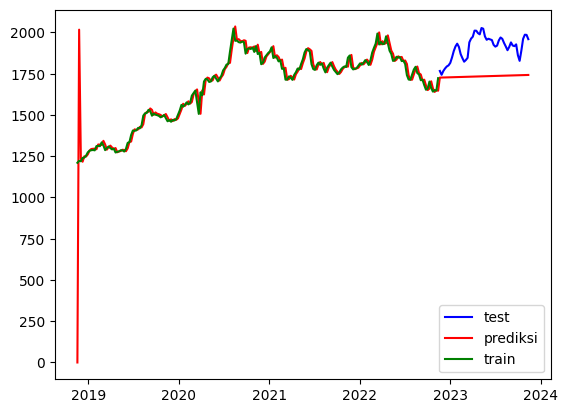

In [85]:
fungsi_arima(traintrend, testtrend, (0, 2, 2), False)

In [86]:
grid_Arima(trainstationer, pdq, True)

,parameter,aic
20,"(2, 0, 2)",1443.54927


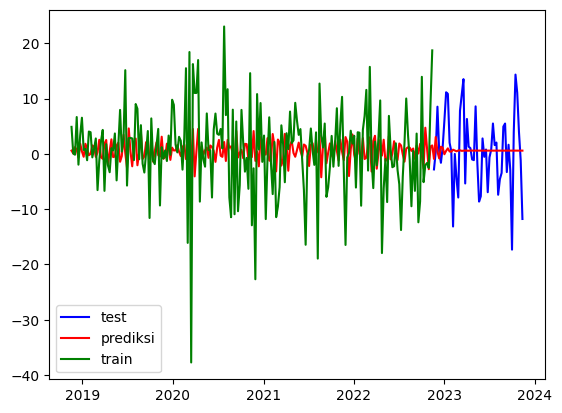

In [89]:
fungsi_arima(trainstationer, teststationer, (2, 0, 2), True)